# 1. Import and Install Dependencies

In [1]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
!pip install opencv-python mediapipe scikit-learn matplotlib

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [15]:
#영상 10;03 웹캠으로 입력 받기 기본 코드 
cap = cv2.VideoCapture(0)
print(cap.isOpened())

while cap.isOpened():
    ret,frame = cap.read()
    cv2.imshow("OpenCV Feed", frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True


In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model): 
    #image = feed frame
    #model = Holistic model
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR -> RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB -> BGR
    return image, results

In [5]:
#rendering function signiture 설명 보기
mp_drawing.draw_landmarks??

In [6]:
#default rendering functions
def draw_landmarks(image, results):
    #visualizing landmarks to the frame
    #image = frame from openCV
    #result = mediapipe_detection 함수의 반환값 = frame의 landmark 정보
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [32]:
#connection_drawing_spec 커스텀 (optional)
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), #draw landmarks(dot)
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #draw connections(line)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [64]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [65]:
#result의 landmark 값 출력해보기
#화면에 보이지 않았다면 landmark 생성되지 않음 -> no value return
len(results.face_landmarks.landmark)
len(results.pose_landmarks.landmark)
len(results.left_hand_landmarks.landmark)
len(results.right_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

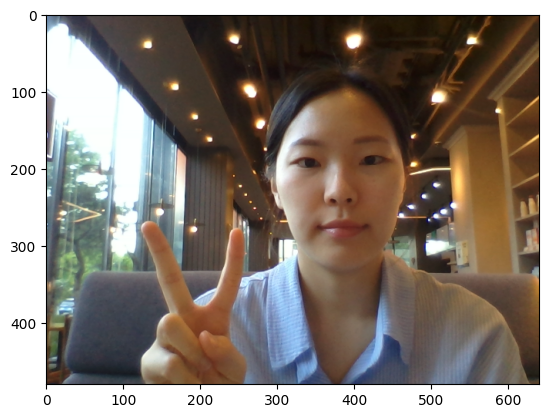

In [66]:
#frame = feed에서 가장 마지막으로 저장한 frame
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) 

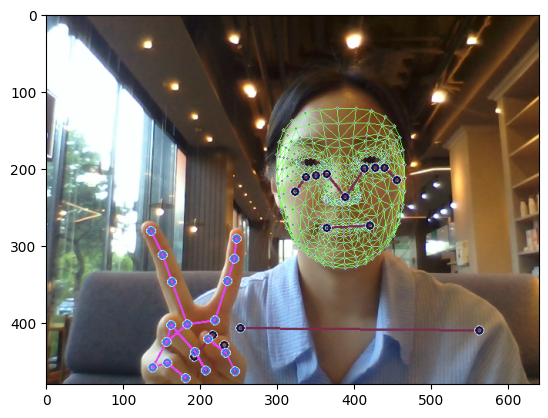

In [67]:
#results = feed에서 가장 마지막으로 저장한 frame의 landmark 정보
draw_styled_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) 

# 3. Extract Keypoint Values
results의 landmarks값 -> numpy array로 변환하기

In [7]:
def extract_keypoints(results):
    #result의 landmarks의 모든 key point values -> 하나의 numpy array 로 flatten
    #if landmarks has no value, fill numpy array with zero
    if results.pose_landmarks: #pose landmarks
        pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() 
    else:
        pose = np.zeros(132) #33*4

    if results.face_landmarks: #face landmarks
        face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() 
    else:
        face = np.zeros(1404) #488*3

    if results.left_hand_landmarks: #left hand landmarks
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() 
    else:
        lh = np.zeros(63) #21*3

    if results.right_hand_landmarks: #right hand landmarks
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() 
    else:
        rh = np.zeros(63) #21*3
    
    return np.concatenate([pose, face, lh, rh])

In [8]:
result_test = extract_keypoints(results)
#size of result_test = 132+1404+63+63 = 1t62
result_test.shape

NameError: name 'results' is not defined

# 4. Setup Folders for Collection

In [9]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

#num of videos
no_sequences = 30

# 1 Video = 30 frames
sequence_length = 30

In [10]:
for action in actions: #make directory for each actions
    for sequence in range(no_sequences): #make directory for each videos per action
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [97]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                #print(results)
                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    #output text to screen
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000) #wait 2seconds
                    
                else: 
                    #output text to screen
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results) #results of frame -> numpy array
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints) #save numpy array in directory

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [94]:
#for cap release
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}
#{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [13]:
#create two blank arrays
sequences, labels = [], [] 
#sequences(=videos) = feature data = x data 
#labels = label data = y data

for action in actions: #actions = hello, thanks, iloveyou
    for sequence in range(no_sequences): #each action has 30 sequences(=videos)
        window = []
        for frame_num in range(sequence_length): #each sequence(=video) has 30 frames
            #each frame has a numpy array that represents the keypoint of the frame
            #numpy array's shape = (1662, )
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        
        #map label
        sequences.append(window)
        labels.append(label_map[action])

In [101]:
np.array(sequences).shape
#(90, 30, 1662)
#total 90 videos(3 actions * 30 videos per action)
#30 frames each video
#1662 keypoint values per frame

(90, 30, 1662)

In [102]:
np.array(labels).shape
#(90, )
#1 label mapped per video

(90,)

In [14]:
X = np.array(sequences)

In [15]:
y = to_categorical(labels).astype(int) 
#converted label from int to binary array
#1 -> [1,0,0], 2 -> [0,1,0], 3 -> [0,0,1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
#split x,y data into train data and test data
#train data 95%, test data size 5% 

In [82]:
X_train.shape
#(85, 30, 1662)

(85, 30, 1662)

In [83]:
X_test.shape
#(5, 30, 1662)

(5, 30, 1662)

In [84]:
y_train.shape
#(85, 3)

(85, 3)

In [85]:
y_test.shape
#(5, 3)

(5, 3)

# 7. Build and Train LSTM Neural Network

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard 

In [18]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
#tensor board is used to monitor neural network training and it's accuracy

In [19]:
#build neural network architecture
model = Sequential()

#add 3 lstm layers
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
#64 lstm units, set return_sequences = true to stack lstm layers together
#input shape = 30 frames per prediction * 1662 keypoints per frame 
model.add(LSTM(128, return_sequences=True, activation='relu'))
#128 lstm units, set return_sequences = true
model.add(LSTM(64, return_sequences=False, activation='relu'))
#64 lstm units, set return_sequences = false (means end of lstm layers)

#add 3 dense layers (dense = fully connected neural network)
model.add(Dense(64, activation='relu'))
#64 dense units
model.add(Dense(32, activation='relu'))
#32 dense units
model.add(Dense(actions.shape[0], activation='softmax'))
#activation function =  softmax (return values within 0~1, make sum of all values added up to 1)
#actions.shape[0] (=size of actions) = 3 (hello, thanks, iloveyou)

In [20]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#optimizer function 원하는 것으로 변경 가능

#loss function 변경 불가능 
#multi-class classification model을 사용할 때는 loss function 반드시 categorical_crossentropy 사용해야
#binary-class classification model을 사용할 때는 loss function 반드시 binary_crossentropy 사용해야

#metrics 생략 가능
#metrics로 model의 accuracy tracking 가능

In [110]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
3/3 [==============================] - 5s 62ms/step - loss: 2.2662 - categorical_accuracy: 0.2588
Epoch 2/1000
3/3 [==============================] - 0s 67ms/step - loss: 1.2412 - categorical_accuracy: 0.3882
Epoch 3/1000
3/3 [==============================] - 0s 77ms/step - loss: 4.9674 - categorical_accuracy: 0.3765
Epoch 4/1000
3/3 [==============================] - 0s 68ms/step - loss: 4.2776 - categorical_accuracy: 0.3412
Epoch 5/1000
3/3 [==============================] - 0s 74ms/step - loss: 12.9437 - categorical_accuracy: 0.2824
Epoch 6/1000
3/3 [==============================] - 0s 70ms/step - loss: 11.7844 - categorical_accuracy: 0.3412
Epoch 7/1000
3/3 [==============================] - 0s 77ms/step - loss: 5.5445 - categorical_accuracy: 0.2588
Epoch 8/1000
3/3 [==============================] - 0s 76ms/step - loss: 3.9349 - categorical_accuracy: 0.2706
Epoch 9/1000
3/3 [==============================] - 0s 82ms/step - loss: 2.4660 - categorical_accuracy: 0.3294

3/3 [==============================] - 0s 80ms/step - loss: 1.0968 - categorical_accuracy: 0.3529
Epoch 147/1000
3/3 [==============================] - 0s 78ms/step - loss: 1.0968 - categorical_accuracy: 0.3529
Epoch 148/1000
3/3 [==============================] - 0s 67ms/step - loss: 1.0968 - categorical_accuracy: 0.3529
Epoch 149/1000
3/3 [==============================] - 0s 69ms/step - loss: 1.0968 - categorical_accuracy: 0.3529
Epoch 150/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.0969 - categorical_accuracy: 0.3529
Epoch 151/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.0961 - categorical_accuracy: 0.3529
Epoch 152/1000
3/3 [==============================] - 0s 76ms/step - loss: 1.0845 - categorical_accuracy: 0.3529
Epoch 153/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.0969 - categorical_accuracy: 0.3529
Epoch 154/1000
3/3 [==============================] - 0s 79ms/step - loss: 1.0968 - categorical_accuracy: 0.352

3/3 [==============================] - 0s 76ms/step - loss: 1.0943 - categorical_accuracy: 0.3529
Epoch 291/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.0945 - categorical_accuracy: 0.3529
Epoch 292/1000
3/3 [==============================] - 0s 79ms/step - loss: 1.0942 - categorical_accuracy: 0.3529
Epoch 293/1000
3/3 [==============================] - 0s 75ms/step - loss: 1.0941 - categorical_accuracy: 0.3529
Epoch 294/1000
3/3 [==============================] - 0s 83ms/step - loss: 1.0942 - categorical_accuracy: 0.3529
Epoch 295/1000
3/3 [==============================] - 0s 68ms/step - loss: 1.0940 - categorical_accuracy: 0.3529
Epoch 296/1000
3/3 [==============================] - 0s 79ms/step - loss: 1.0936 - categorical_accuracy: 0.3529
Epoch 297/1000
3/3 [==============================] - 0s 77ms/step - loss: 1.0933 - categorical_accuracy: 0.3529
Epoch 298/1000
3/3 [==============================] - 0s 67ms/step - loss: 1.0933 - categorical_accuracy: 0.352

3/3 [==============================] - 0s 102ms/step - loss: 0.7443 - categorical_accuracy: 0.6706
Epoch 435/1000
3/3 [==============================] - 0s 85ms/step - loss: 0.7562 - categorical_accuracy: 0.6706
Epoch 436/1000
3/3 [==============================] - 0s 75ms/step - loss: 0.7323 - categorical_accuracy: 0.6706
Epoch 437/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.7602 - categorical_accuracy: 0.6706
Epoch 438/1000
3/3 [==============================] - 0s 65ms/step - loss: 0.7583 - categorical_accuracy: 0.6000
Epoch 439/1000
3/3 [==============================] - 0s 79ms/step - loss: 0.7614 - categorical_accuracy: 0.6000
Epoch 440/1000
3/3 [==============================] - 0s 86ms/step - loss: 0.7367 - categorical_accuracy: 0.6353
Epoch 441/1000
3/3 [==============================] - 0s 84ms/step - loss: 0.7337 - categorical_accuracy: 0.6706
Epoch 442/1000
3/3 [==============================] - 0s 92ms/step - loss: 0.7409 - categorical_accuracy: 0.65

3/3 [==============================] - 0s 66ms/step - loss: 0.5776 - categorical_accuracy: 0.6824
Epoch 579/1000
3/3 [==============================] - 0s 73ms/step - loss: 0.5750 - categorical_accuracy: 0.6824
Epoch 580/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.5737 - categorical_accuracy: 0.6824
Epoch 581/1000
3/3 [==============================] - 0s 75ms/step - loss: 0.5762 - categorical_accuracy: 0.6824
Epoch 582/1000
3/3 [==============================] - 0s 69ms/step - loss: 0.5728 - categorical_accuracy: 0.6824
Epoch 583/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.5735 - categorical_accuracy: 0.6824
Epoch 584/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.5718 - categorical_accuracy: 0.6824
Epoch 585/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.5729 - categorical_accuracy: 0.6824
Epoch 586/1000
3/3 [==============================] - 0s 66ms/step - loss: 0.5714 - categorical_accuracy: 0.682

3/3 [==============================] - 0s 76ms/step - loss: 1.0094 - categorical_accuracy: 0.4824
Epoch 723/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.9972 - categorical_accuracy: 0.6235
Epoch 724/1000
3/3 [==============================] - 0s 75ms/step - loss: 0.9904 - categorical_accuracy: 0.5412
Epoch 725/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.9688 - categorical_accuracy: 0.6000
Epoch 726/1000
3/3 [==============================] - 0s 76ms/step - loss: 0.9659 - categorical_accuracy: 0.5882
Epoch 727/1000
3/3 [==============================] - 0s 65ms/step - loss: 0.9535 - categorical_accuracy: 0.5412
Epoch 728/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.9400 - categorical_accuracy: 0.6000
Epoch 729/1000
3/3 [==============================] - 0s 65ms/step - loss: 0.9190 - categorical_accuracy: 0.5294
Epoch 730/1000
3/3 [==============================] - 0s 66ms/step - loss: 0.8917 - categorical_accuracy: 0.552

3/3 [==============================] - 0s 95ms/step - loss: 0.3707 - categorical_accuracy: 0.8588
Epoch 867/1000
3/3 [==============================] - 0s 73ms/step - loss: 0.3849 - categorical_accuracy: 0.8353
Epoch 868/1000
3/3 [==============================] - 0s 91ms/step - loss: 0.3393 - categorical_accuracy: 0.8941
Epoch 869/1000
3/3 [==============================] - 0s 85ms/step - loss: 0.2949 - categorical_accuracy: 0.9059
Epoch 870/1000
3/3 [==============================] - 0s 85ms/step - loss: 0.2940 - categorical_accuracy: 0.8824
Epoch 871/1000
3/3 [==============================] - 0s 77ms/step - loss: 1.2610 - categorical_accuracy: 0.4824
Epoch 872/1000
3/3 [==============================] - 0s 77ms/step - loss: 1.8410 - categorical_accuracy: 0.5647
Epoch 873/1000
3/3 [==============================] - 0s 68ms/step - loss: 1.5167 - categorical_accuracy: 0.3529
Epoch 874/1000
3/3 [==============================] - 0s 68ms/step - loss: 1.4881 - categorical_accuracy: 0.352

In [111]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

# 8. Make Predictions

In [22]:
predict_res = model.predict(X_test)

1/1 [==============================] - 1s 611ms/step


In [23]:
#y_test의 값은 각 label에 해당할 확률 값 ex.[0.1, 0.2, 0.7]
#y_test의 값이 가리키는 label 값 = 가장 큰 값을 가진 값
actions[np.argmax(predict_res[4])]

'hello'

In [24]:
#y_test의 값은 binary array 형식 ex.[0, 0, 1]
#y_test의 값이 가리키는 label 값 = 1을 가진 값
actions[np.argmax(y_test[4])]

'hello'

# 9. Save Weights

In [140]:
#단일 file/folder 에 모델의 아키텍처, 가중치 및 훈련 구성을 저장
model.save('action.h5')

In [45]:
del model

In [21]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [25]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [26]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 34ms/step


In [27]:
#y_test의 값들이 가리키는 label들을 하나의 리스트로 변환
#ex. [[0, 0, 1], [0, 1, 0]] -> [2, 1]
ytrue = np.argmax(y_test, axis=1).tolist()
#yhat의 값들이 가리키는 label들을 하나의 리스트로 변환
#ex. [[0.1, 0.2, 0.7], [0.1, 0.8, 0.1]] -> [2, 1]
yhat = np.argmax(yhat, axis=1).tolist()

In [28]:
#returns a confusion matrix sorted by the label order
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 1],
        [0, 3]],

       [[3, 0],
        [1, 1]]], dtype=int64)

In [29]:
accuracy_score(ytrue, yhat)

0.8

# 11. Test in Real Time

In [30]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

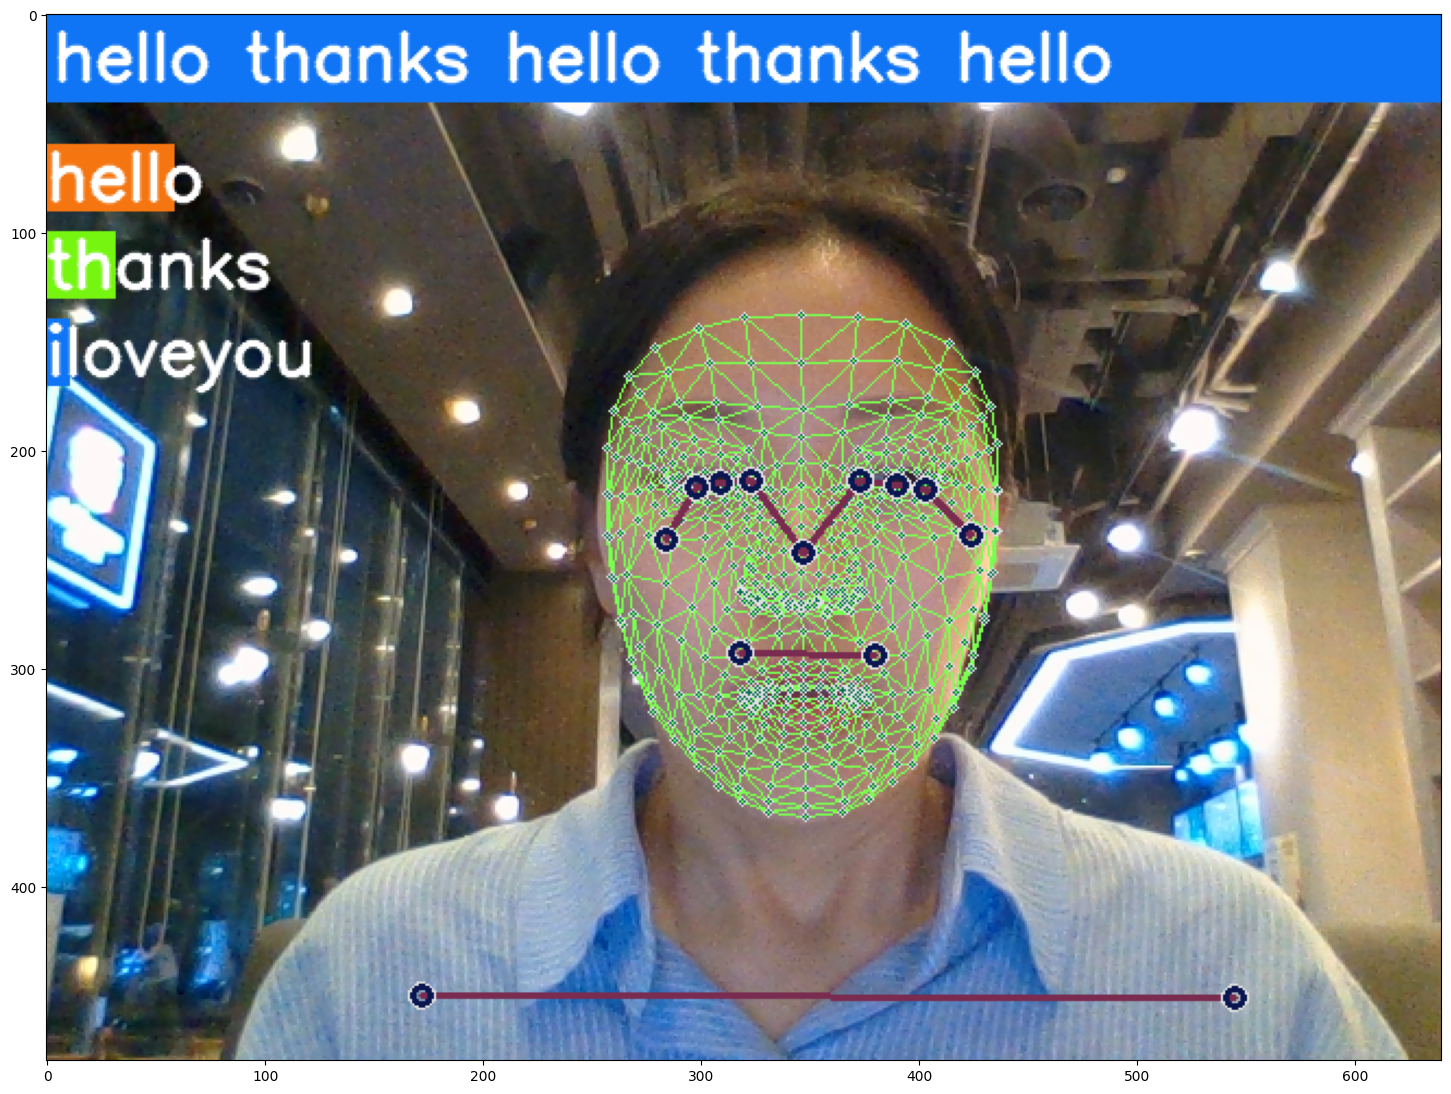

In [149]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), colors))

In [33]:
# 1. New detection variables
sequence = [] #collect 30 frames to make a sequence(=video)
sentence = [] #concatenate history of predictions together
threshold = 0.5

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:] #generate sequence with last 30 frames
        
        if len(sequence) == 30:
            #sequence.shape = (30, 1662)
            #the input shape model expects = (number of sequences, 30, 1662)
            res = model.predict(np.expand_dims(sequence, axis=0))[0] #predict one sequence at a time
            print(actions[np.argmax(res)])
            
            #3. Rendering logic
            #ex. res = [0.1, 0.2, 0.7]
            #np.argmax(res) = 2, res[np.argmax(res)] = 0.7
            if res[np.argmax(res)] > threshold: 
                
                if len(sentence) > 0: 
                    #sentence에 저장된 prediction이 있는 경우 
                    #새로운 prediction인 경우에만 sentence에 추가
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else: 
                    #sentence에 저장된 prediction 없는 경우 바로 sentence에 추가
                    sentence.append(actions[np.argmax(res)])
            
            #sentence가 너무 길어지지 않도록 마지막 5개의 prediction만 유지
            if len(sentence) > 5: 
                sentence = sentence[-5:]

            #Visualize probabilities
            image = prob_viz(res, actions, image, colors)
            
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
            # Show to screen
            cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
thanks
<class 'mediapipe.p

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==================

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 37ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==================

1/1 [==============================] - 0s 33ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.p